This is similar to the Logistic Regression experiment, but we now reduce the problem to only distinguishing between 1's and 7's.
This reduces the number of parameters in our model, in turn reducing the cost of computing the influence.
Furthermore, we will have fewer training and test points to iterate through.

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from influence.influence_model import InfluenceModel

## Data

We use the MNIST dataset, consisting of images of handwritten digits, and their respective labels.

In [62]:
mnist_dataset = tf.keras.datasets.mnist
(full_train_images, full_train_labels), (full_test_images, full_test_labels) = mnist_dataset.load_data()

train_images = full_train_images[(full_train_labels == 1) | (full_train_labels == 7)]
train_labels = full_train_labels[(full_train_labels == 1) | (full_train_labels == 7)]

test_images = full_test_images[(full_test_labels == 1) | (full_test_labels == 7)]
test_labels = full_test_labels[(full_test_labels == 1) | (full_test_labels == 7)]

train_images = train_images / 255.0
test_images = test_images / 255.0

categorical_train_labels = (train_labels==1).astype(np.float64).reshape((-1,1))
categorical_test_labels = (test_labels==1).astype(np.float64).reshape((-1,1))

In [57]:
categorical_train_labels[0]

array([1.])

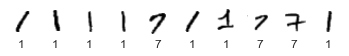

In [7]:
plt.figure()
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [9]:
print("Number of training points: ", len(train_images))
print("Number of test points: ", len(test_images))

Number of training points:  13007
Number of test points:  2163


## Model

We use a logistic regression model to classify each image.

In [63]:
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(1, kernel_regularizer='l2', bias_regularizer='l2')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

*Note: As Scipy uses float64 by default, running our model in float64 saves time by reducing need for casting.*

*Note: Auto-differentiation is not supported for tf.keras.losses.SparseCategoricalCrossentropy(), hence we use tf.keras.losses.CategoricalCrossentropy() instead, and we have processed our labels as needed.*

In [64]:
model.fit(
    train_images,
    categorical_train_labels,
    epochs=1,
    validation_split=0.1
)

Train on 11706 samples, validate on 1301 samples
11706/11706 [==============================] - 1s 89us/sample - loss: 0.1835 - accuracy: 0.9522 - val_loss: 0.0880 - val_accuracy: 0.9954


## Influence

For a given test image, we can find the most influential training images, according to both influence functions and RelatIF.

*Note: Currently iterating through a much smaller subset of the training images, as it is computationally expensive.*

In [52]:
full_train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [65]:
influence_model = InfluenceModel(
    model,
    train_images,
    categorical_train_labels,
    model.loss,
    0,
    damping=0.2,
    dtype=np.float64
)

%time influence_model.get_inverse_hvp()

Wall time: 983 ms


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.53536715e-06,  1.73935300e-05,
        2.27886274e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [82]:
%%time
num_training_points = 1000
num_test_points = 10

influence_functions = np.zeros((num_training_points, num_test_points))
theta_relatif = np.zeros((num_training_points, num_test_points))
l_relatif = np.zeros((num_training_points, num_test_points))

for i in range(num_training_points):
    
    influence_model = InfluenceModel(
        model,
        train_images,
        categorical_train_labels,
        model.loss,
        i,
        damping=0.2,
        dtype=np.float64
    )
    
    for j in range(num_test_points):
        influence_functions[i,j] = influence_model.get_influence_on_loss(test_images[j], categorical_test_labels[j])
        theta_relatif[i,j] = influence_model.get_theta_relatif(test_images[j], categorical_test_labels[j])
        l_relatif[i,j] = influence_model.get_l_relatif(test_images[j], categorical_test_labels[j])

Wall time: 16min 34s


In [83]:
sorted_if = np.argsort(influence_functions, axis=0)
sorted_theta = np.argsort(theta_relatif, axis=0)
sorted_l = np.argsort(l_relatif, axis=0)

In [114]:
is_one = tf.reshape((model(test_images[:num_test_points]) > 0.5), (1, -1)).numpy()[0]

In [115]:
predictions = np.full(num_test_points, 7)
predictions[is_one] = 1

### Influence Functions

In [85]:
num_most_influential = 5
num_shown_test_points = 10

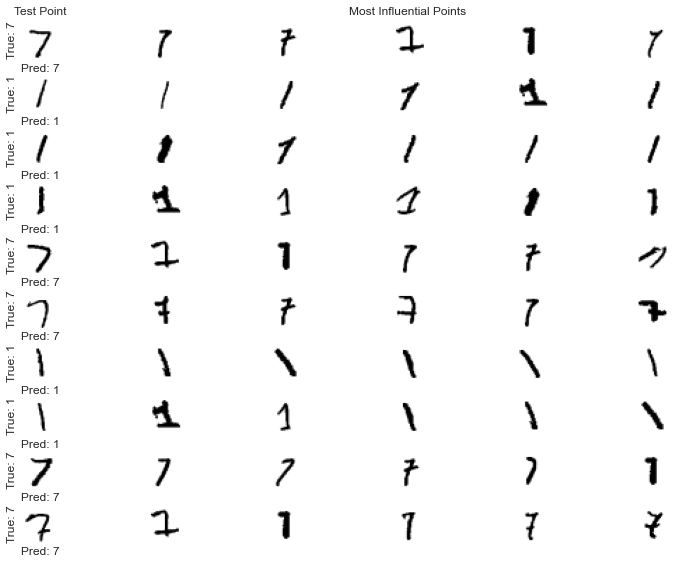

In [116]:
fig, ax = plt.subplots(
    num_shown_test_points,
    num_most_influential+1,
    subplot_kw={'xticks':[], 'yticks':[]},
    figsize=(12.8, 9.6)
)
fig.subplots_adjust(hspace=0.4)

ax[0,0].set_title("Test Point")
ax[0,(num_most_influential+1)//2].set_title("Most Influential Points")

for i in range(num_shown_test_points):
    ax[i,0].imshow(test_images[i], cmap=plt.cm.binary)
    ax[i,0].set_xlabel("Pred: " + str(predictions[i]))
    ax[i,0].set_ylabel("True: " + str(test_labels[i]))
    for j in range(num_most_influential):
        ax[i,j+1].imshow(train_images[sorted_if[j,i]], cmap=plt.cm.binary)

In [87]:
# Number of unique training points in k-most influential.
len(np.unique(sorted_if[:num_most_influential]))

30

### $\theta$-RelatIF

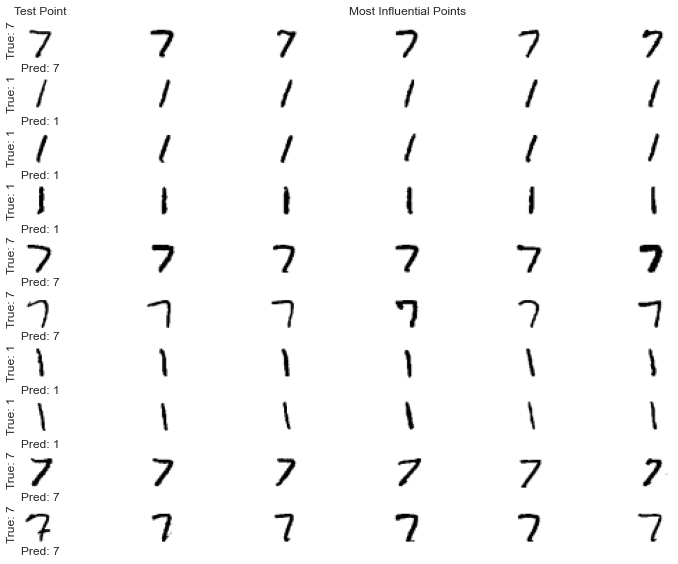

In [117]:
fig, ax = plt.subplots(
    num_shown_test_points,
    num_most_influential+1,
    subplot_kw={'xticks':[], 'yticks':[]},
    figsize=(12.8, 9.6)
)
fig.subplots_adjust(hspace=0.4)

ax[0,0].set_title("Test Point")
ax[0,(num_most_influential+1)//2].set_title("Most Influential Points")

for i in range(num_shown_test_points):
    ax[i,0].imshow(test_images[i], cmap=plt.cm.binary)
    ax[i,0].set_xlabel("Pred: " + str(predictions[i]))
    ax[i,0].set_ylabel("True: " + str(test_labels[i]))
    for j in range(num_most_influential):
        ax[i,j+1].imshow(train_images[sorted_theta[j,i]], cmap=plt.cm.binary)

In [89]:
# Number of unique training points in k-most influential.
len(np.unique(sorted_theta[:num_most_influential]))

46